In [2]:
!pip install imantics --quiet

In [3]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


C:\Users\DANYA\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [8]:
base_dir = 'C:/Users/DANYA/Desktop/Zatop/Test'
images_dir = f'{base_dir}/zatopp' 
masks_dir = f'{base_dir}/Mask' 

In [9]:
images_listdir = os.listdir(images_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)
print(images_listdir[0:3])

['0.jpg', '1.jpg', '10.jpg']


In [10]:
image_size=512
input_image_size=(512,512)

In [11]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size))
    return img

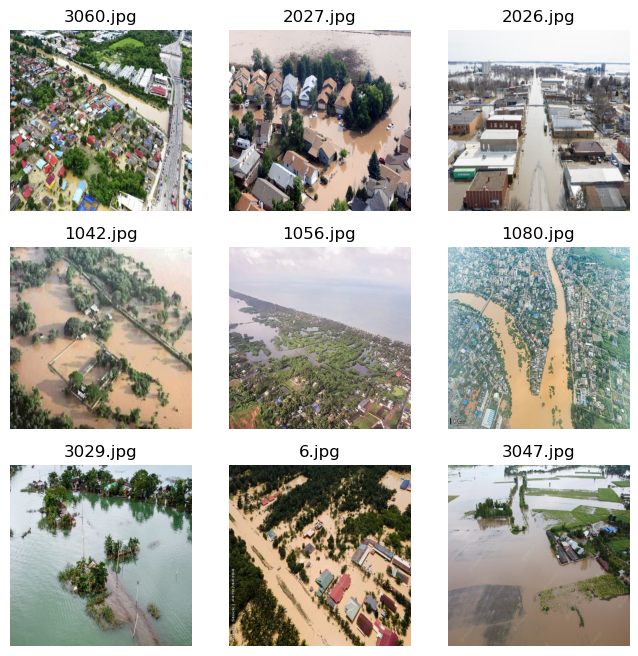

In [12]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (8,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        #print(img.shape)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

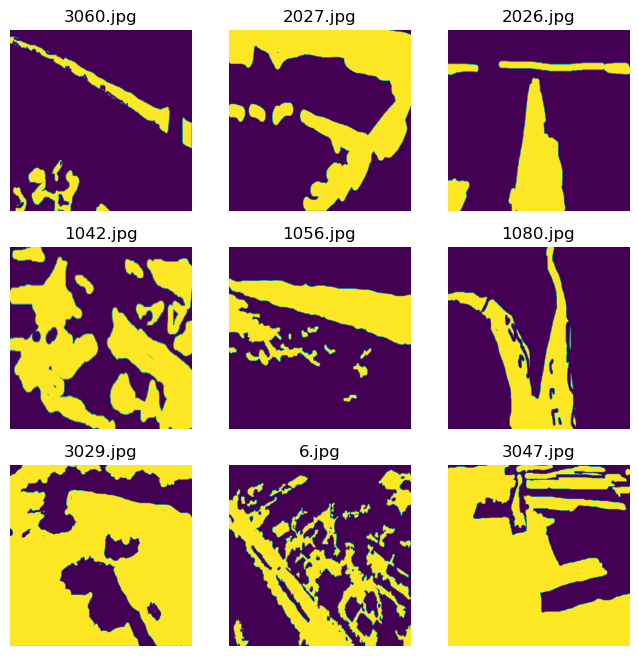

In [13]:
fig, ax = plt.subplots(rows, cols, figsize = (8,8))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i][0:-4]+'.png'
        img = read_image(f"{masks_dir}/{file}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

In [14]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:51]): ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])

        file2=file[0:-4]+'.png'
        mask = read_image(f"{masks_dir}/{file2}") 
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)    
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

0.jpg


In [15]:
images=np.array(IMAGES)[1:51]
masks=np.array(MASKS)[1:51]
print(images.shape,masks.shape)

(50, 512, 512, 3) (50, 512, 512, 1)


In [17]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

In [18]:
print(len(images_train), len(masks_train))

40 40


In [19]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 32, 32, 1024)         0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 32, 32, 1024)         9438208   ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 32, 32, 1024)         4096      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activatio

 )                                                                   'activation_1[0][0]']        
                                                                                                  
 conv2d_16 (Conv2D)          (None, 512, 512, 64)         73792     ['concatenate_3[0][0]']       
                                                                                                  
 batch_normalization_16 (Ba  (None, 512, 512, 64)         256       ['conv2d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 512, 512, 64)         0         ['batch_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_17

In [20]:
unet_result = unet_model.fit(
    images_train, masks_train, 
    validation_split = 0.2, batch_size = 4, epochs = 40)

Epoch 1/40
8/8 [==============================] - 458s 54s/step - loss: -271.0924 - accuracy: 0.3957 - val_loss: 5068.0781 - val_accuracy: 0.5046
Epoch 2/40
8/8 [==============================] - 364s 45s/step - loss: -452.9509 - accuracy: 0.4579 - val_loss: 218340.5312 - val_accuracy: 0.5046
Epoch 3/40
8/8 [==============================] - 340s 43s/step - loss: -497.2443 - accuracy: 0.4709 - val_loss: 5000369.0000 - val_accuracy: 0.5046
Epoch 4/40
8/8 [==============================] - 332s 42s/step - loss: -572.9342 - accuracy: 0.4117 - val_loss: 1065257.5000 - val_accuracy: 0.5046
Epoch 5/40
8/8 [==============================] - 330s 42s/step - loss: -627.2636 - accuracy: 0.3430 - val_loss: 1713362.7500 - val_accuracy: 0.5046
Epoch 6/40
8/8 [==============================] - 329s 42s/step - loss: -678.7828 - accuracy: 0.2632 - val_loss: 265716.8125 - val_accuracy: 0.5046
Epoch 7/40
8/8 [==============================] - 335s 42s/step - loss: -750.7135 - accuracy: 0.2142 - val_loss

In [27]:
unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 15s 15s/step


In [28]:
unet_predict1 = (unet_predict > 0.1).astype(np.uint8)
unet_predict2 = (unet_predict > 0.2).astype(np.uint8)
unet_predict3 = (unet_predict > 0.3).astype(np.uint8)
unet_predict4 = (unet_predict > 0.4).astype(np.uint8)

In [29]:
len(unet_predict)

10

In [30]:
def show_result(og, unet, target, p):
    
    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original")
    axs[0].imshow(og)
    axs[0].axis('off')
    
    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')
    
    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

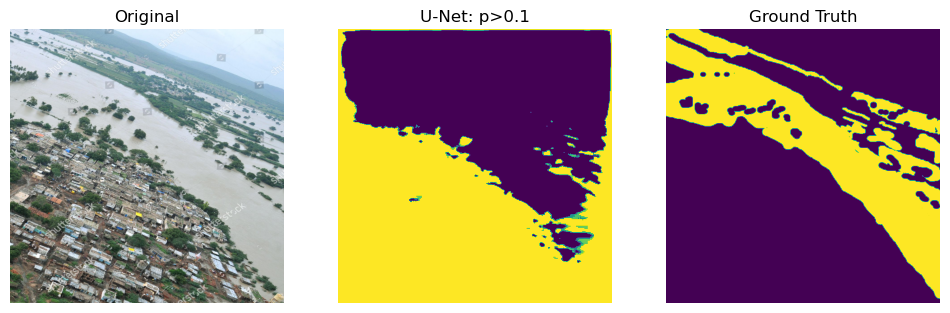

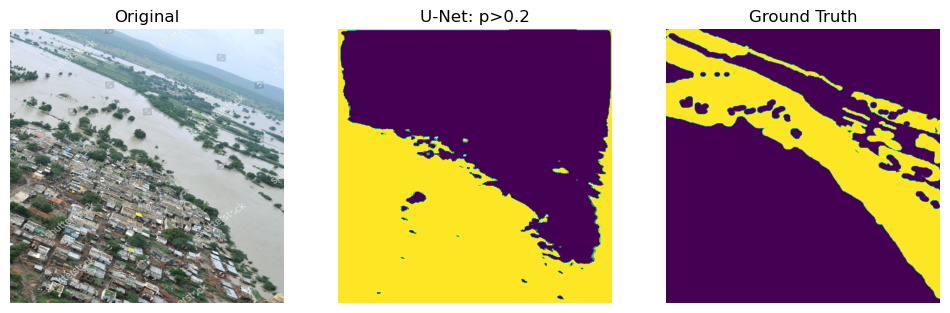

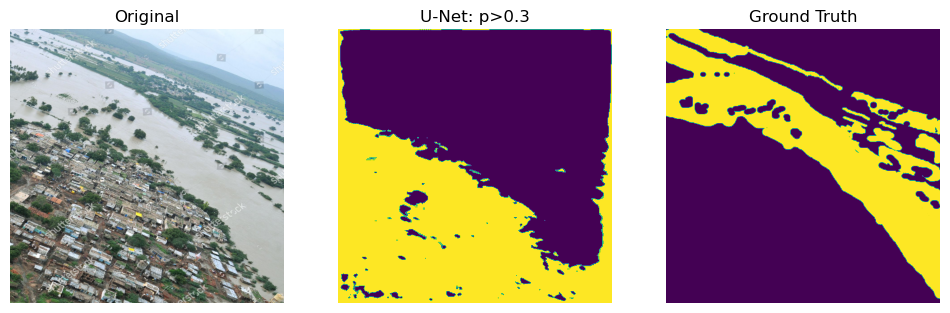

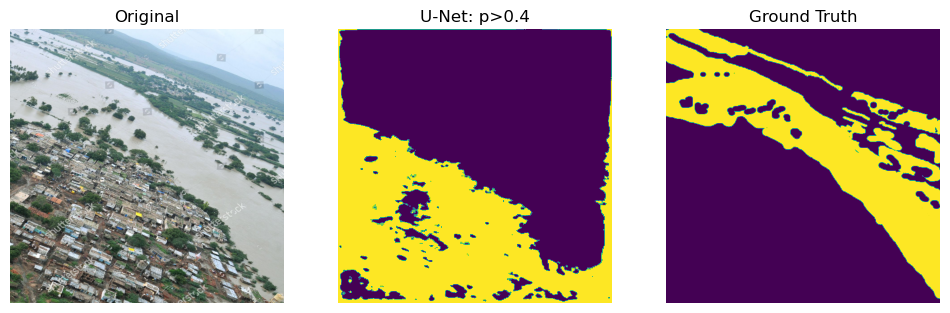

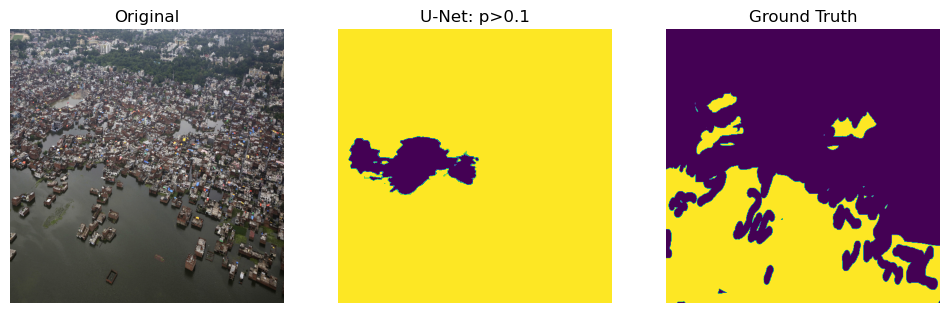

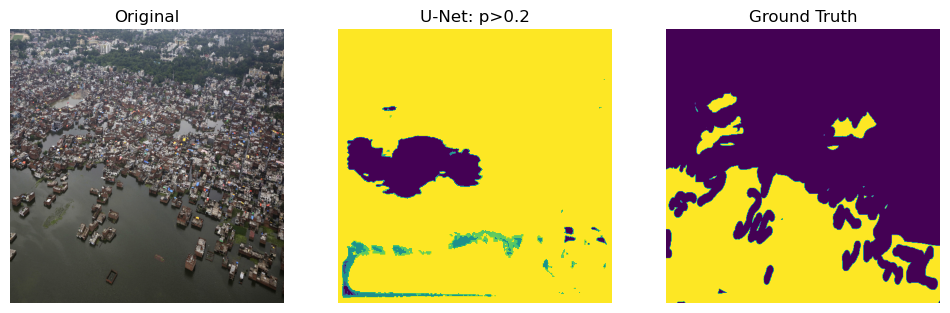

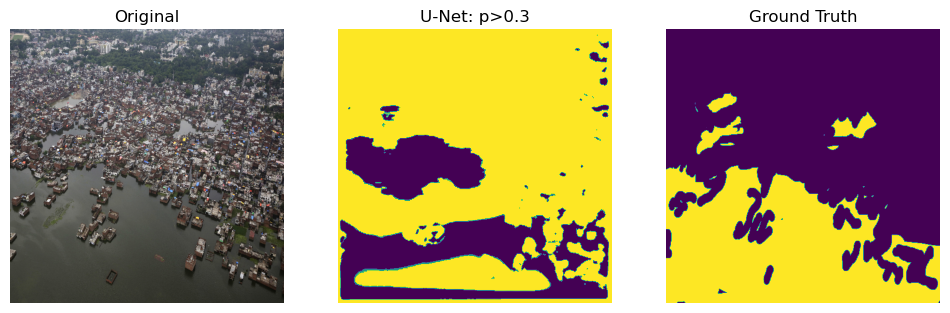

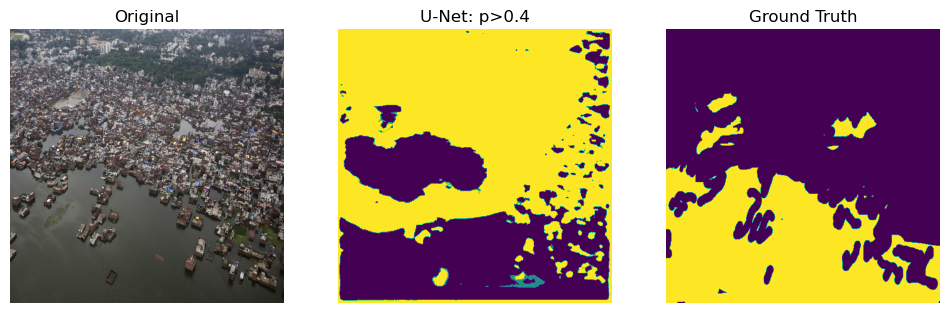

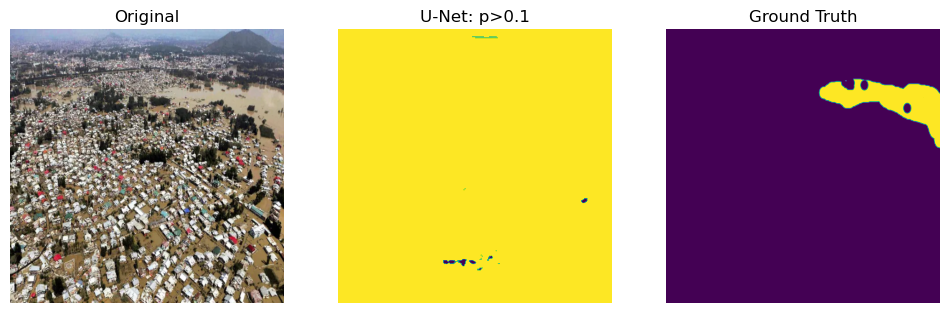

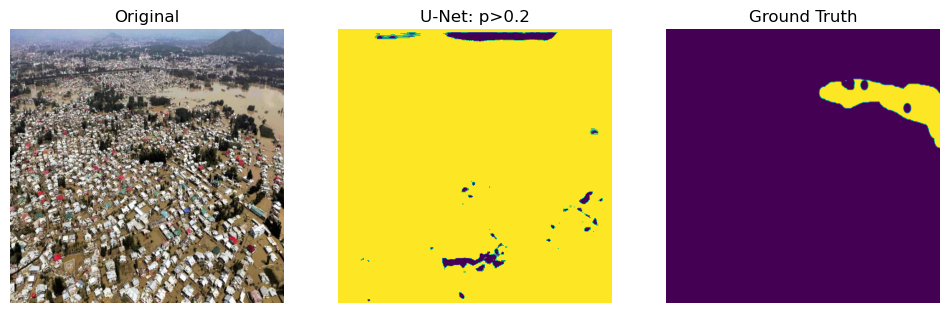

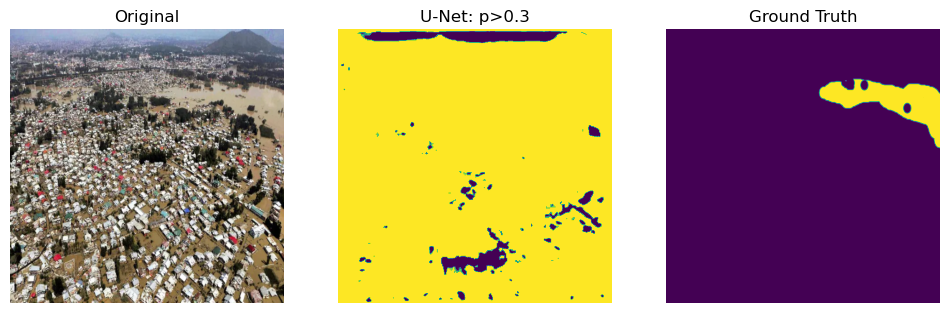

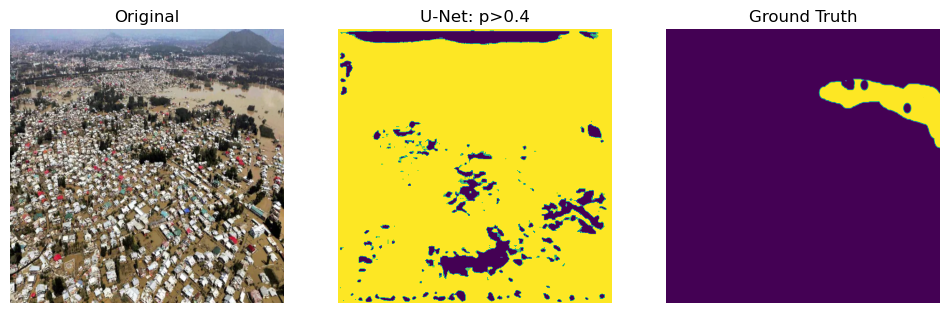

In [31]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx: 
    show_result(images_test[idx], unet_predict1[idx], masks_test[idx], 0.1)
    show_result(images_test[idx], unet_predict2[idx], masks_test[idx], 0.2)
    show_result(images_test[idx], unet_predict3[idx], masks_test[idx], 0.3)
    show_result(images_test[idx], unet_predict4[idx], masks_test[idx], 0.4)